# Determining the lightcurves of stellar clusters

The purpose of this notebook is to download large (1 deg by 1 deg) FFIs of several clusters, create a mask isolating the sky pixels, and use that mask to subtract the background from the lightcurves. Each of these three steps will have their own parts. The clusters we will investigate are:

- M34
- M7
- NGC 752
- IC 2391
- NGC 6231
- Lambda Orionis (might be on the edge of the TESS field)
- NGC 3532
- Collinder 140

and we will also investigate these globular clusters:

- Omega Cen
- 47 Tuc
- M4
- NGC 6752.

In [36]:
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt

CLUSTERS = ["M34", "M7", "NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Collinder 140"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.78449002, 9.93415587), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113", "-31.85"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "M4": (245.89675, -26.52575), 
          "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

## 1. Downloading the FFIs

We will start by downloading the FFIs of these clusters with `lightkurve`. However, if the file has already been downloaded, we will load it from the disk instead.

In [38]:
tpfs = [0]*len(CLUSTERS)

for i in range(len(CLUSTERS)):
    foundLocal = False
    for file in os.listdir(LIGHTKURVE_CACHE):
        if file.endswith("180x180_astrocut.fits"): # Confirm size
            if COORDS[CLUSTERS[i]][0] == float(file.split("_")[-4]): # Confirm RA
                if COORDS[CLUSTERS[i]][1] == float(file.split("_")[-3]): # Confirm dec
                    tpfs[i] = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                    foundLocal = True
                    break
    if not foundLocal:
        search = lk.search_tesscut(CLUSTERS[i])
        char = ""
        if len(search) != 1: char = "s"
        print("{0} has {1} result{2}.".format(CLUSTERS[i], len(search), char))
        tpfs[i] = search[0].download(cutout_size=180)

M7 has 1 result.


HTTPError: The TESS FFI cutout service at MAST appears to be temporarily unavailable. It returned the following error: 504 Server Error: Gateway Time-out for url: https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=268.46325&dec=-34.79283&y=180&x=180&units=px&sector=13

Now we will display the tpfs. We pick a frame in the middle of the exposure to avoid edge effects. Some of the clusters appear on the edge of a sector, which causes them to be partially cut off.

In [ ]:
for i in range(len(CLUSTERS)):
    p = tpfs[i].plot(frame=tpfs[i].shape[0] // 2)
    p.set_title(CLUSTERS[i])

## 2. Creating the sky mask

In this part, we will create a mask that isolates the sky pixels from the others for use in background subtraction.

To determine sky pixels, we will make a histogram of the brightness of the pixels in the particular cadence shown above. We expect as many as four peaks; from lowest to highest brightness they represent

1. Black pixels because they are on the edge of the sector
2. Sky pixels
3. Star pixels
4. Saturated pixels

/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


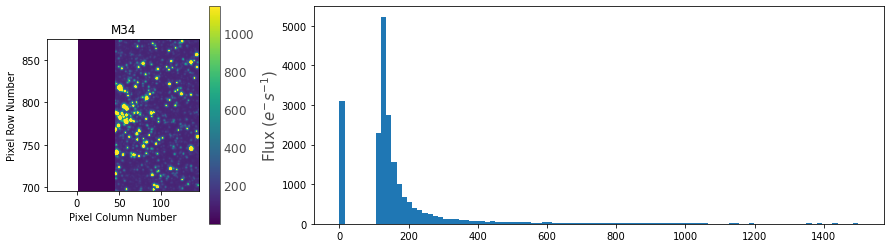

In [6]:
for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    brightnessData = tpfs[i][frame].flux.reshape(180*180)
    upper_limit = 1500
    lower_limit = 0
    brightnessData = brightnessData[np.where((brightnessData >= lower_limit) & (brightnessData <= upper_limit))]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
    tpfs[i].plot(ax=ax1, frame=tpfs[i].shape[0] // 2)
    ax1.set_title(CLUSTERS[i])
    
    ax2.hist(brightnessData, bins=100)

Now that we have an idea of what the data looks like, we can actually create the sky mask.

In [ ]:
masks = [0] * len(CLUSTERS)

for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    upper_limit = 150
    masks[i] = ((tpfs[i][frame].flux >= 10) & # Exclude edge pixels
        (tpfs[i][frame].flux <= upper_limit)).reshape(180, 180)

Finally, we display the mask by displaying all the sky pixels and setting the non-sky pixels equal to zero.

In [ ]:
for i in range(len(CLUSTERS)):
    frame = tpfs[i].shape[0]//2
    maskedFlux = np.ma.array(tpfs[i][frame].flux, mask=~masks[i]).reshape(180, 180).filled(fill_value=0)
    plt.imshow(maskedFlux, vmin=0, vmax=np.nanpercentile(tpfs[i][frame].flux, 95))
    #p = tpfs[i].plot(frame=tpfs[i].shape[0] // 2, aperture_mask=mask[i])
    #p.set_title(CLUSTERS[i])

## 3. Creating the lightcurves

In this section, we will apply the mask defined above and create a lightcurve based on it using the standard `lightkurve` method. First, we create the uncorrected lightcurves:

In [ ]:
lightcurves = [tpfs[i].to_lightcurve(aperture_mask=~masks[i]) for i in range(len(CLUSTERS))];

Then, we subtract the background radiation and create a new lightcurve.

In [ ]:
NUMBER_PCA_COMPONENTS = 10

regressors = [tpfs[i].flux[:, masks[i]] for i in range(len(CLUSTERS))]# The regressor is the inverse of the aperture

dms = [lk.DesignMatrix(r, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant() for r in regressors]
correctors = [lk.RegressionCorrector(lc) for lc in lightcurves]
correctedLCs = [correctors[i].correct(dms[i]) for i in range(len(CLUSTERS))]

Finally, we draw the new lightkurve and compare it to the un-corrected one.

In [ ]:
for i in range(len(CLUSTERS)):
    plot = lightcurves[i].plot(marker='.', ls='none', color='r');# This is where you would flatten the curves
    plot2 = correctedLCs[i].plot(marker='.', ls='none', color='b');# This is where you would flatten the curves
    plot.set_title("TESS 2-min lightcurve for {0}: automatic aperture".format(CLUSTERS[i]));
    plot2.set_title("TESS 2-min lightcurve for {0}: automatic aperture, corrected".format(CLUSTERS[i]));

I'm not sure I've done this totally correctly.